In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, auc, classification_report, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pprint
import pandas as pd
import xgboost as xgb

In [ ]:
train_df = pd.read_csv('data.csv')
test_df = pd.read_parquet('data-val.parquet')

In [ ]:
## Make sure that the dataset 

# Find common columns
common_columns = train_df.columns.intersection(test_df.columns)

# Drop uncommon columns
removed_columns = set(train_df.columns).symmetric_difference(test_df.columns)
train_df_filtered = train_df[common_columns]
test_df_filtered = test_df[common_columns]

# Print removed columns
print("Removed columns:", removed_columns)

Removed columns: {'SUM_NOT_TRANSFER_3m', 'Unnamed: 0.1', 'SUM_AMT_TRANSFER_3m'}


In [ ]:
# Comparing number of columns
print("Train data:", train_df_filtered.shape[1])
print("Test data:", test_df_filtered.shape[1])

Train data: 57
Test data: 57


In [ ]:
## Dropping irrelavant columns

# Train_data
train_df_filtered = train_df_filtered.drop(columns=['Age_x','CIF_CLSCUS', 'COB_DATE', 'DATE_TIME', 'BRN_OPN_CIF', 'MA_PHONG_GIAO_DICH_VCB', 'CIF_MASK', 'IS_TM', 'Unnamed: 0', 'SUM_CBALQ_LH_6m', 'SUM_CBALQ_LH_3m', 'AVG_GR_SUM_CBALQ_LH'])

# Test_data 
test_df_filtered = test_df_filtered.drop(columns=['Age_x','CIF_CLSCUS', 'COB_DATE', 'DATE_TIME', 'BRN_OPN_CIF', 'MA_PHONG_GIAO_DICH_VCB', 'CIF_MASK', 'IS_TM', 'Unnamed: 0', 'SUM_CBALQ_LH_6m', 'SUM_CBALQ_LH_3m', 'AVG_GR_SUM_CBALQ_LH'])

In [ ]:
# Comparing number of columns
print("Train data:", train_df_filtered.shape[1])
print("Test data:", test_df_filtered.shape[1])
print('Selected columns:\n', test_df_filtered.columns)

Train data: 45
Test data: 45
Selected columns:
 Index(['CBALQ_3m', 'AVG_SL_SP_BOSUNG', 'NO_TREN_CO_6m',
       'LOAIHINHCOQUANDANGCONGTAC', 'SUM_CBALQ_LH', 'BHNT_flag',
       'MEDIAN_GR_SUM_AMT', 'TINHTRANGSOHUUNHA', 'TINHTRANGHONNHAN', 'Khu_vuc',
       'BHNT_after21', 'Sum_PPC', 'MEDIAN_GR_THGCO', 'BHSK_remain',
       'IS_BANCAS', 'AVG_GR_CBALQ', 'CBALQ_6m', 'AVG_CBALQ_6m', 'BHNT_remain',
       'AVG_GR_THGCO', 'IS_TM.1', 'Age_y', 'THGCO_3m', 'CNT_TGCCKH',
       'THGNO_6m', 'IS_TA', 'TONGTHUNHAPHANGTHANG', 'Snapshot', 'BHSK_flag',
       'THGCO_6m', 'MEDIAN_GR_CBALQ', 'AVG_CBALQ_TGCCKH', 'THGNO_3m',
       'TINHCHATCONGVIECHIENTAI', 'AVG_AMT_3M', 'NO_TREN_CO_3m',
       'AVG_CBALQ_3m', 'Prio_flag', 'SONGUOIPHUTHUOC', 'THOIGIANLAMVIECLVHT',
       'BHSK_after21', 'Payroll_Flag', 'AVG_GR_THGNO', 'CUS_GEN',
       'MEDIAN_GR_THGNO'],
      dtype='object')


In [ ]:
# Replacing inf values with nan

train_df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
target_distribution = train_df_filtered['IS_BANCAS'].value_counts(normalize=True)
print(target_distribution)
class_counts = train_df_filtered['IS_BANCAS'].value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]  #

IS_BANCAS
0.0    0.952381
1.0    0.047619
Name: proportion, dtype: float64


In [ ]:
# Model

# Combine the train and test dataframes
combined_df = pd.concat([train_df_filtered, test_df_filtered], axis=0, ignore_index=True)

# Generate dummy variables for the combined dataframe
# combined_df = pd.get_dummies(combined_df, drop_first=True)  # drop_first avoids dummy and

# Check for duplicate column names
# Strip whitespace and normalize names
# combined_df.columns = combined_df.columns.str.strip().str.replace("  ", " ").str.replace(" ", "_")

# duplicate_columns = [col for col in combined_df.columns if combined_df.columns.tolist().count(col) > 1]
# print("Duplicate Columns:", duplicate_columns)
# combined_df = combined_df.drop(columns = duplicate_columns)
# combined_df = combined_df.drop(columns = [
#     'LOAIHINHCOQUANDANGCONGTAC_Tổng_công_ty/Tập_đoàn_kinh_tế_Nhà_nước;_Các_ngân_hàng_thương_mại,_công_ty_bảo_hiểm,_công_ty_đa_quốc',
#     'THOIGIANLAMVIECLVHT_Từ_3_đến_dưới_4_năm',
#     'THOIGIANLAMVIECLVHT_Từ_4_năm_đến_dưới_5_năm'
# ])

# print(combined_df.columns.size)
# print(combined_df.columns.sort)

In [ ]:
# Model


# Split the combined dataframe back into train and test sets
train_df = combined_df.iloc[:len(train_df_filtered), :]  # Rows corresponding to train_df
test_df = combined_df.iloc[len(train_df_filtered):, :]  # Rows corresponding to test_df

# Split data into features and target
X_train = train_df.drop(columns=['IS_BANCAS'])
y_train = train_df['IS_BANCAS']
X_test = test_df.drop(columns=['IS_BANCAS'])
y_test = test_df['IS_BANCAS']
print(X_test.columns)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)


# Initialize XGBoost with scale_pos_weight
xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss', 
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Save the model
with open('results/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_clf, f)

# model = pickle.load(open("results/xgb_model.pkl", "rb"))


Index(['CBALQ_3m', 'AVG_SL_SP_BOSUNG', 'NO_TREN_CO_6m', 'SUM_CBALQ_LH',
       'BHNT_flag', 'MEDIAN_GR_SUM_AMT', 'BHNT_after21', 'Sum_PPC',
       'MEDIAN_GR_THGCO', 'BHSK_remain', 'AVG_GR_CBALQ', 'CBALQ_6m',
       'AVG_CBALQ_6m', 'BHNT_remain', 'AVG_GR_THGCO', 'IS_TM.1', 'Age_y',
       'THGCO_3m', 'CNT_TGCCKH', 'THGNO_6m', 'IS_TA', 'TONGTHUNHAPHANGTHANG',
       'Snapshot', 'BHSK_flag', 'THGCO_6m', 'MEDIAN_GR_CBALQ',
       'AVG_CBALQ_TGCCKH', 'THGNO_3m', 'AVG_AMT_3M', 'NO_TREN_CO_3m',
       'AVG_CBALQ_3m', 'BHSK_after21', 'Payroll_Flag', 'AVG_GR_THGNO',
       'MEDIAN_GR_THGNO',
       'LOAIHINHCOQUANDANGCONGTAC_Các trường hợp khác (bao gồm cá nhân tự kinh doanh)',
       'LOAIHINHCOQUANDANGCONGTAC_Các tổ chức, doanh nghiệp, định chế tài chính khác',
       'LOAIHINHCOQUANDANGCONGTAC_Các định chế tài chính có XHTD là AAA, AA, A+, A, BBB, BB+',
       'LOAIHINHCOQUANDANGCONGTAC_Các định chế tài chính có XHTD là BB, B+, B, CCC',
       'LOAIHINHCOQUANDANGCONGTAC_Các định chế tài chí

c:\Users\ZALMT\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Testing

## On training data
y_pred_xgb_train = xgb_clf.predict_proba(X_train)[:, 1]
y_pred_xgb_train_lab = xgb_clf.predict(X_train)

## On testing data
y_pred_xgb_test = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb_test_lab = xgb_clf.predict(X_test)

# ## On training data
# y_pred_xgb_train = model.predict_proba(X_train)[:, 1]
# y_pred_xgb_train_lab = model.predict(X_train)

# ## On testing data
# y_pred_xgb_test = model.predict_proba(X_test)[:, 1]
# y_pred_xgb_test_lab = model.predict(X_test)

In [ ]:
# Reporting

## On training data
print('\nTESTING ON TRAINING DATA:\n')

accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train_lab)
accuracy_xgb_train = round(accuracy_xgb_train, 4)
roc_auc_score_xgb_train = roc_auc_score(y_train, y_pred_xgb_train)
gini_xgb_train = 2 * roc_auc_score_xgb_train - 1

print('Model Accuracy:', str(accuracy_xgb_train * 100))
print('\nClassification Report:')
print(classification_report(y_train, y_pred_xgb_train_lab))
print("ROC AUC Score:", roc_auc_score_xgb_train.round(2))
print("Gini Index:", gini_xgb_train.round(2))

## On testing data
print('\nTESTING ON TESTING DATA:\n')

accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb_test_lab)
accuracy_xgb_test = round(accuracy_xgb_test, 4)
roc_auc_score_xgb_test = roc_auc_score(y_test, y_pred_xgb_test)
gini_xgb_test = 2 * roc_auc_score_xgb_test - 1

print('Model Accuracy:', str(accuracy_xgb_test * 100))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_xgb_test_lab))
print("ROC AUC Score:", roc_auc_score_xgb_test.round(2))
print("Gini Index:", gini_xgb_test.round(2))


TESTING ON TRAINING DATA:

Model Accuracy: 86.13

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92   1036620
         1.0       0.23      0.83      0.36     51831

    accuracy                           0.86   1088451
   macro avg       0.61      0.85      0.64   1088451
weighted avg       0.95      0.86      0.90   1088451

ROC AUC Score: 0.93
Gini Index: 0.85

TESTING ON TESTING DATA:

Model Accuracy: 83.7

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.91    130200
         1.0       0.19      0.74      0.30      6510

    accuracy                           0.84    136710
   macro avg       0.59      0.79      0.60    136710
weighted avg       0.95      0.84      0.88    136710

ROC AUC Score: 0.87
Gini Index: 0.75


In [ ]:
# ROC Curves

## Train data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_xgb_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Insert root point (0,0) into fpr and tpr
fpr_train = [0] + list(fpr_train)
tpr_train = [0] + list(tpr_train)

## Test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_xgb_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Insert root point (0,0) into fpr and tpr
fpr_test = [0] + list(fpr_test)
tpr_test = [0] + list(tpr_test)

In [ ]:
# Colours
background_color = '#181926'
text_colour = "#cad3f5"
axis_colour = "#b8c0e0"
guess_colour = '#8aadf4'
roc_train_colour = "#f0c6c6"
roc_test_colour = "#91d7e3"

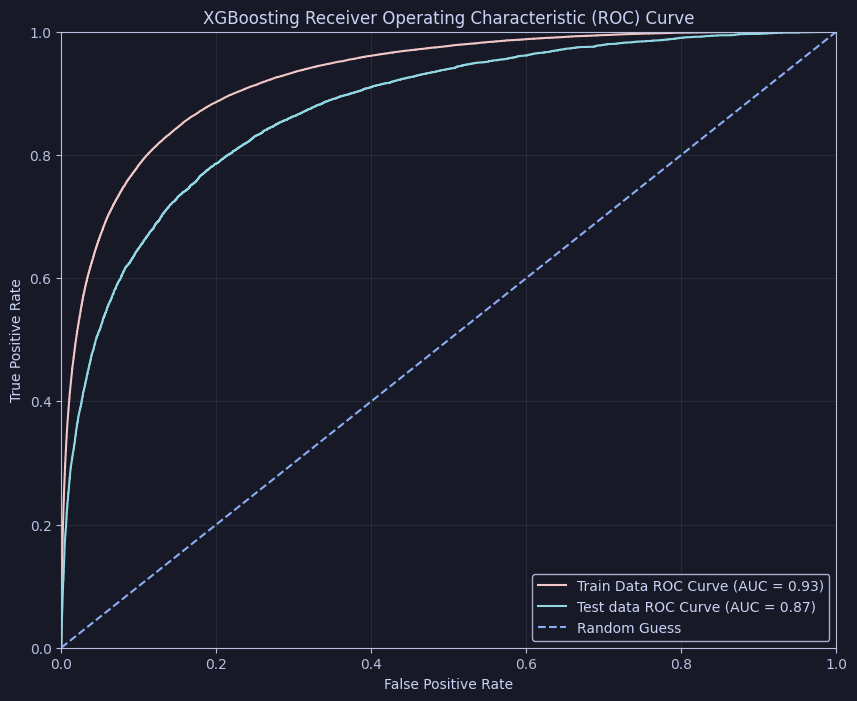

In [ ]:
# Setting up the plot
plt.figure(figsize=(10, 8), facecolor=background_color)
ax = plt.gca()  # Get the current Axes
ax.set_facecolor(background_color)  # Set the background color of the Axes

# Customize axis colors
ax.tick_params(axis='x', colors=axis_colour)  # Set x-axis tick color
ax.tick_params(axis='y', colors=axis_colour)  # Set y-axis tick color
ax.spines['bottom'].set_color(axis_colour)  # Set bottom spine color
ax.spines['left'].set_color(axis_colour)    # Set left spine color
ax.spines['top'].set_color(axis_colour)  # Set bottom spine color
ax.spines['right'].set_color(axis_colour)    # Set left spine color

# Plotting

# Plot the ROC curve
plt.plot(fpr_train, tpr_train, color=roc_train_colour, label=f'Train Data ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color=roc_test_colour, label=f'Test data ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color=guess_colour, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate', color=text_colour)  # White text for better contrast
plt.ylabel('True Positive Rate', color=text_colour)  # White text for better contrast
plt.title('XGBoosting Receiver Operating Characteristic (ROC) Curve', color=text_colour)
plt.legend(loc='lower right', facecolor=background_color, edgecolor=text_colour, labelcolor=text_colour)
plt.grid(alpha=0.1, color=axis_colour)  # Adjust grid line color for visibility

# Set the x and y limits to start at 0
plt.xlim(0, 1)  # x-axis starts at 0
plt.ylim(0, 1)  # y-axis starts at 0
plt.savefig('results/XGBoost_ROC.png')
plt.show()